# Dados Faltantes (<em>Missing Data</em>)

Imaginar que os dados obtidos de sensores irão sempre produzir <em>datasets</em> limpos pode ser considerado uma utopia. Diversos problemas podem ocorrer no processo de aquisiçao de dados ou no transporte desses até a Nuvem, como problemas físico com o <em>hardware</em> dos sensores, falta de energia, problemas com conectividade, dentre outros.
É comum que os <em>datasets</em> apresentem dados faltantes, duplicados, confusos, insuficientes ou que tenha presença de valores atípicos (<em>outliers</em>). Em resumo, dados faltantes são inevitáveis. 

Para ajudar a solucuonar problemas como este, cientistas e analistas de dados ou analistas de negócios devem conhecer a natureza pela qual o conjunto de dados analizado pertence. Por exemplo, num <em>dataset</em> que representa dados ambientais, não é comum que encontremos um valor 9999 para temperatura. Não é um valor esperado para temperatura.

Existem algumas técnicas para trabalhar com Dados Faltantes, mas as que abordaremos neste curso são a <strong>imputação</strong> e <strong>interpolação</strong>.

Todos os exemplos utilizados nesta prática são baseados nos mesmos exemplos do livro <a href="https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook">Time Series Analysis with Python - Cookbook</a>

## Requisitos técnicos
Iremos trabalhar com dois <em>datasets</em> nos exemplos:
- Emissões de CO2, com dados anuais obtidos através de relatórios do portal <a href="https://ourworldindata.org/">Our World in Data</a>. Disponível em <a href="https://ourworldindata.org/co2-emissions">https://ourworldindata.org/co2-emissions</a>.
- Fluxo de cliques em e-shop, disponível em <a href="https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping">https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping</a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np

Será necessário o uso intenso da biblioteca pandas e outras quatro bibliotecas:
- Numpy (≥ 1.20.3)
- Matplotlib (≥ 3.5.0)
- statsmodels (≥ 0.11.0)
- scikit-learn (≥ 1.0.1)
- SciPy (≥ 1.7.1)

Se você estiver usando pip, basta instalar os pacotes com o seguinte comando no seu terminal:
 ```
 pip install matplotlib numpy statsmodels scikit-learn scipy
```

Se você estiver usando conda, então você pode instalar as bibliotecas com o seguinte comando:
```
conda install matplotlib numpy statsmodels scikit-learn scipy
```

In [4]:
import matplotlib
import sklearn
import statsmodels as sm

print(f'''
pandas -> {pd.__version__}
numpy -> {np.__version__}
matplotlob -> {matplotlib.__version__}
statsmodels -> {sm.__version__}
scikit-learn -> {sklearn.__version__}
''')



pandas -> 1.0.5
numpy -> 1.23.1
matplotlob -> 3.5.2
statsmodels -> 0.13.4
scikit-learn -> 1.1.3



### Funções necessárias para as práticas

#### ```read_dataset()```

In [5]:
def read_dataset(url, date_col):
    '''
     date_col: especifica uma coluna de data para ser usada como coluna de índice
    
    Por praticidade e pela possibilidade de executar este notebook na Nuvem, opta-se pela utilização de 
    URL's para obter o dataset. Caso você queira utilizar datasets localmente em sua máquina, comente 
    as linhas abaixo que não estão comentadas e descomente as que estão comentadas'''
    df = pd.read_csv(url, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    '''
    #dir: é um objeto de Path #(necessário importar a biblioteca: from pathlib import Path) 
    #arquivo: o nome do arquivo CSV no objeto Path

   
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    '''
    
    #  retorna: pandas DataFrame com um DatetimeIndex
    return df

#### ```plot_df()```

Esta função "plota" gráficos de séries temporais usando uma coluna de parâmetro (```col```). Esta coluna contém os dados faltantes. 

O objetivo da função é comparar dois dataframes: ```df1``` (dataframe original, sem dados faltantes) e ```df2``` para comparar ambos

In [6]:
def plot_df(df1, df2, col, titulo=None, xlabel=None, ylabel=None):
    '''	
    df1: dataframe original (sem dados faltantes)
    df2: dataframe com dados faltantes
    col: nome da coluna que contém dados faltantes
    '''    
    df_f = df2.rename(columns={col: 'faltante'})
    
    colunas = df_f.loc[:, 'faltante':].columns.tolist()
    subplots_t = len(colunas)
   
    fig, ax = plt.subplots(subplots_t+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Dataset Original')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, nomecol in enumerate(colunas):
        df_f[nomecol].plot(ax=ax[i+1])
        ax[i+1].set_title(nomecol)

    plt.show()

### ```indice_rmse()```

Existem algumas abordagens que podem ser adotadas para lidar com dados faltantes. Algumas são mais apropriadas para determinados cenários. Algumas a se destacar:
1. Remoção dos dados faltantes (não indicado, principalmente quando se tem um conjunto pequeno de dados)
2. Criar "etiquetas" para identificar dados faltantes. Ex.: (Se em algum dia, você descobriu que houve falha de energia, você poderia informar isso nos dias em que houve essa falha, para distinguir registros faltantes dos não faltantes)
3. Estimar os dados faltantes. Abriga um conjunto de técnicas que vão desde o simples até o mais sofisticado (de técnicas de ML até modelos estatísticos complexos).
Nós utilizaremos a "raiz quadrada média de erro" (do inglês <em>root mean square error</em> - RSME) entre os valores observados e preditos, conforme a fórmula abaixo:
<img src=" 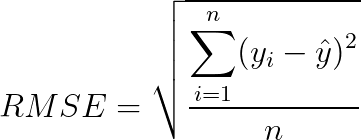"></img>

Onde:
- $Y_i$ é o valor observado
- $\hat{Y}$ é o valor predito (no nosso exemplo, seria o valor faltante)

RSME será utilizada por nós para avaliar os múltiplos métodos de imputação de dados. A técnica é muito utilizada para avaliar a perfomance de modelos preditivos (por exemplo, comparar modelos de regressão). Geralmente, quanto menor o valor RSME, melhor. Ou seja, a fórmula nos diz a distância média entre o valor predito (no nosso caso, onde há dados faltantes) e o valor atual.

In [7]:
def indice_rmse(df1, df2, col=None):
    '''
    df1: dataframe original (sem dados faltantes)
    df2: dataframe com dados faltantes
    col: nome da coluna que contém dados faltantes

    retorna: a lista de índices
    '''
    df_f = df2.rename(columns={col: 'faltante'})
    colunas = df_missing.loc[:, 'faltante':].columns.tolist()
    scores = []
    for comp_col in df_f[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_f[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE de {comp_col}: {rmse}')
    return scores

## Realizando testes de qualidade

Dados faltantes podem representar valores facilmente distinguíveis dos "normais", como
- ```NaN```, ```NaT``` ou ```NA```
- Podem ser substituídos por valores quantitativos, como ```9999``` ou ```0``` (valores com ```0``` sempre devem ser investigados) e valores qualitativos (por exemplo, ```missing```)